# Comparing Model Wind Data to Observed Wind Data

---

## Overview
If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

1. Brief Discussion of the WFIP3 Project
1. Downloading and Plotting Model Data with Herbie
1. Downloading and Plotting Observed Wind Data
1. Comparing Model and Observed Data

## Prerequisites

This notebook will involve use of Herbie and the Atmospheric Community Toolkit (ACT) to download/read in data.  It also relies on MetPy to handle a couple calculations and MatPlotLib for plotting purposes.

| Concepts | Importance | Notes |
| --- | --- | --- |
| ACT | Necessary | |
| Herbie | Necessary | |
| MetPy | Helpful | |
| NumPy | Helpful | |
| MatPlotLib | Necessary | | 

- **Time to learn**: 60 Minutes
- **System requirements** (Preferably the latest version of each):
    - Python
    - ACT
    - MetPy
    - Herbie
    - numpy
    - matplotlib

---

## Imports

In [1]:
import act
from herbie import Herbie
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime, timedelta

## Brief Discussion of the WFIP3 Project

*This section is currently being worked on.  Information will be added here in a future update.*

---

## Downloading and Plotting Model Data with Herbie

We will begin by first looking at model data using a module called Herbie.  Herbie allows us to retrieve archived data from several models, but we will be focusing on the High Resolution Rapid Refresh (HRRR) model.  For now let's just focus on the 24-hour forecast.  You will be asked to input a year, month, and day.

In [2]:
#For best results, try  dates within the range 04/17/2024-05/15/2024 
yr=input('Year (yyyy):')
m=input('Month (mm):')
dd=input('Day (dd):')
H=[]
ds=[]
for a in range(0, 25):
    H.append(Herbie(f"{yr}-{m}-{dd}",  # model run date
        model="hrrr",  # model name
        product="prs", #product
        fxx=a,  # forecast lead time
              ))
    #Keep level set to 1000 mb since that's the closest level to the observed data
    ds.append(H[a].xarray(f":1000 mb:", remove_grib=False))

Year (yyyy): 2024
Month (mm): 05
Day (dd): 03


✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F05 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F07 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F08 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-May-03 00:00 UTC F10 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

### Subsetting for the Three Sites
Here we will subset the data to only the three observation sites:

In [3]:
#We want to find the data at a certain lat/lon point
#Coordinates:
#Rhode Island: 41.4456, -71.4357
#Cape Cod: 42.03, -70.049
#Sodar: 41.2453, -70.105
lat = [41.4456, 42.03, 41.2453]
lon = [-71.4357, -70.049, -70.105]
point_ds=[]
for a in range(0, 25):
    ds[a]['longitude'] = (ds[a]['longitude'] + 180) % 360 - 180
    for b in range(0, 3):
        # First, find the index of the grid point nearest a specific lat/lon
        abslat = np.abs(ds[a].latitude-lat[b])
        abslon = np.abs(ds[a].longitude-lon[b])
        c = np.maximum(abslon, abslat)
        ([yloc], [xloc]) = np.where(c == np.min(c))
        # Now we can use that index location to get the values at the x/y diminsion
        point_ds.append(ds[a].sel(x=xloc, y=yloc))

Now we calculate the wind speed and direction for each time at each site:

In [4]:
#Create new variables for the subset data and run a loop to calculate the values for each
rhod_spd=[]
caco_spd=[]
sodar_spd=[]
rhod_dir=[]
caco_dir=[]
sodar_dir=[]
times=[]
for d in range(0, 75, 3):
    rhod_spd.append((mpcalc.wind_speed(point_ds[d].u.values * units.meter/units.second, point_ds[d].v.values * units.meter/units.second)).m)
    caco_spd.append((mpcalc.wind_speed(point_ds[d+1].u.values * units.meter/units.second, point_ds[d+1].v.values * units.meter/units.second)).m)
    sodar_spd.append((mpcalc.wind_speed(point_ds[d+2].u.values * units.meter/units.second, point_ds[d+2].v.values * units.meter/units.second)).m)
    rhod_dir.append((mpcalc.wind_direction(point_ds[d].u.values * units.meter/units.second, point_ds[d].v.values * units.meter/units.second)).m)
    caco_dir.append((mpcalc.wind_direction(point_ds[d+1].u.values * units.meter/units.second, point_ds[d+1].v.values * units.meter/units.second)).m)
    sodar_dir.append((mpcalc.wind_direction(point_ds[d+2].u.values * units.meter/units.second, point_ds[d+2].v.values * units.meter/units.second)).m)
    times.append(point_ds[d].valid_time.values)

### Plotting the Data
Now it's time to plot the variables.  First we will look at wind speed:

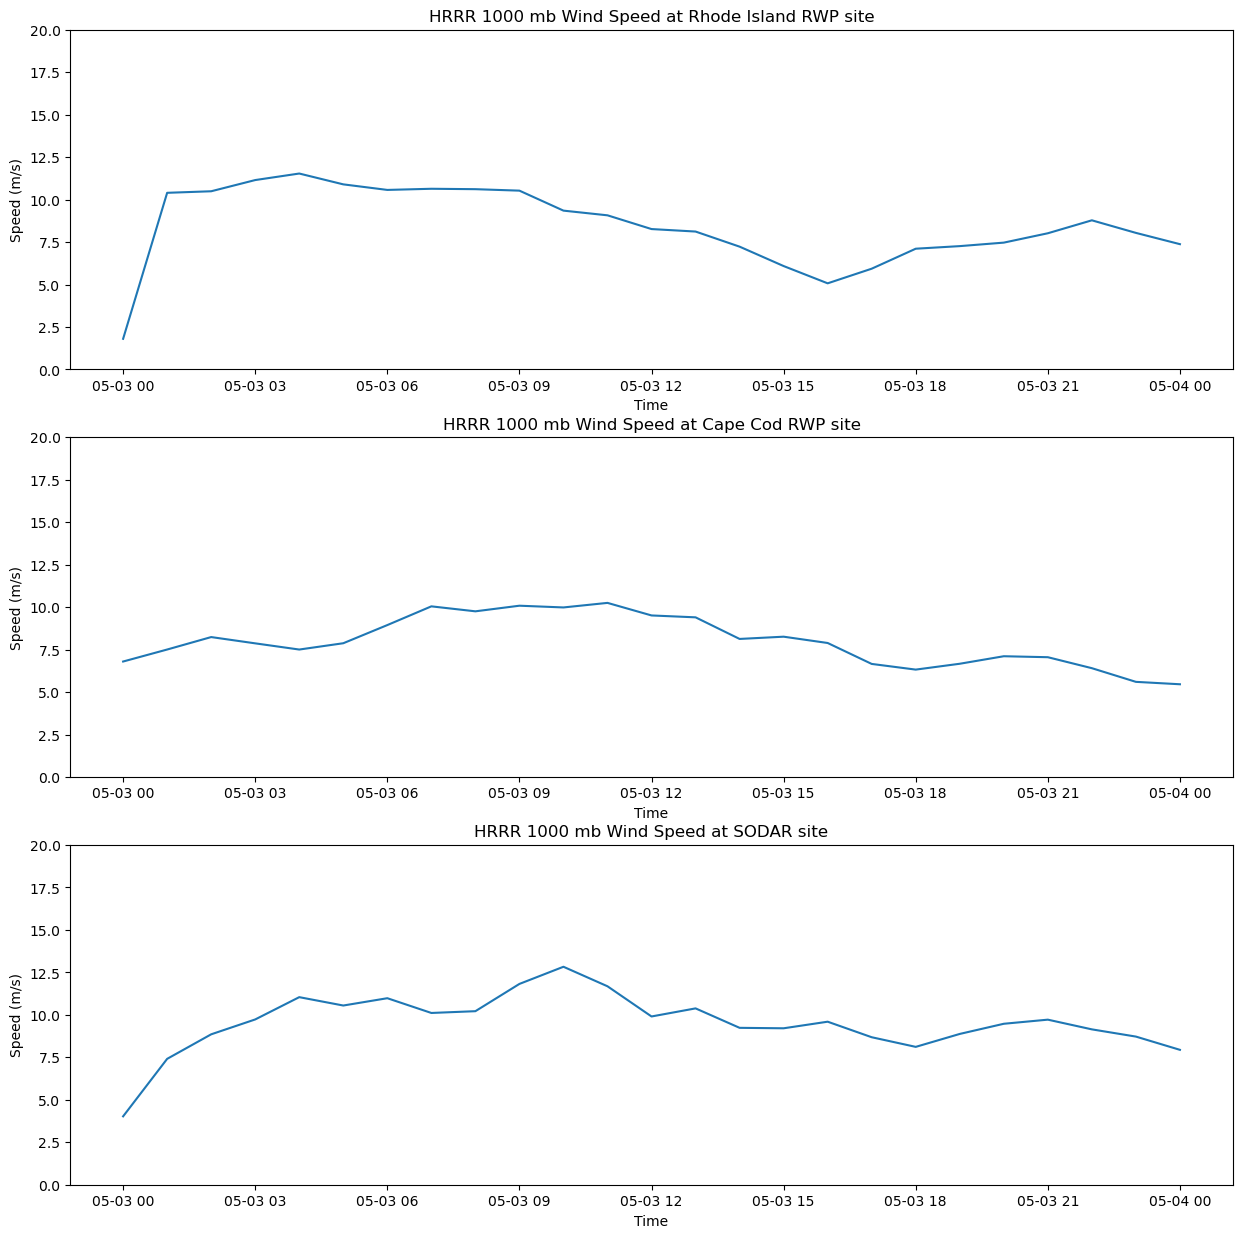

In [5]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(311)
ax.plot(times, rhod_spd)
ax.set_title(f'HRRR 1000 mb Wind Speed at Rhode Island RWP site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax = plt.subplot(312)
ax.plot(times, caco_spd)
ax.set_title(f'HRRR 1000 mb Wind Speed at Cape Cod RWP site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax = plt.subplot(313)
ax.plot(times, sodar_spd)
ax.set_title(f'HRRR 1000 mb Wind Speed at SODAR site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_HRRRspd.png', bbox_inches='tight', dpi=150)

And now wind direction:

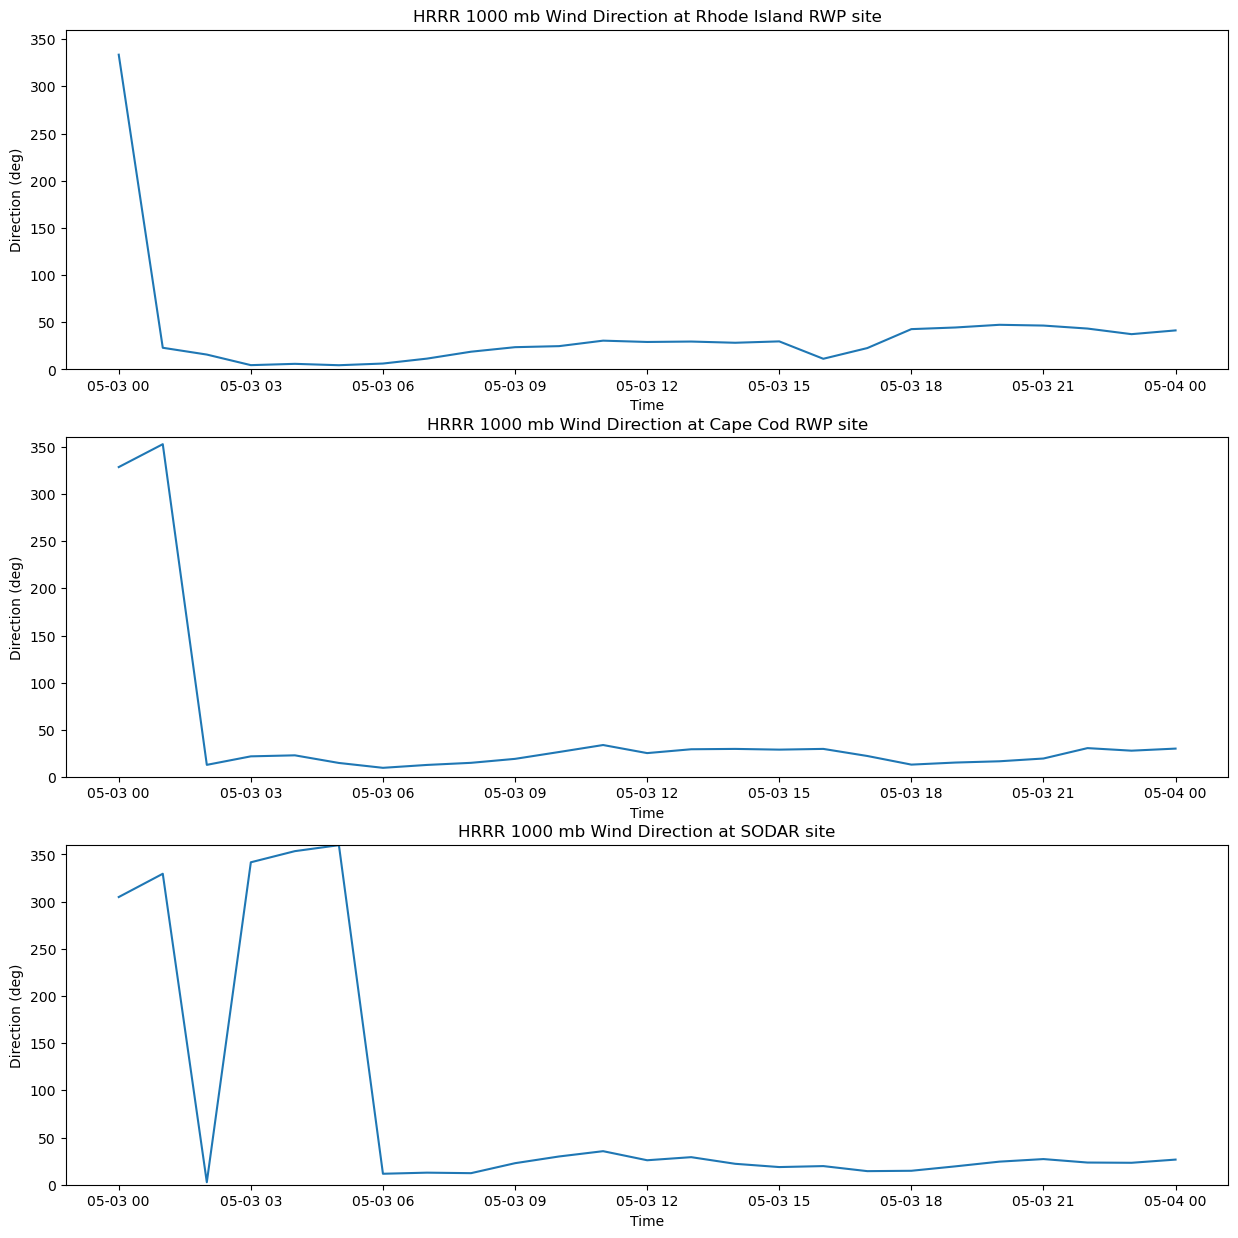

In [6]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(311)
ax.plot(times, rhod_dir)
ax.set_title(f'HRRR 1000 mb Wind Direction at Rhode Island RWP site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax = plt.subplot(312)
ax.plot(times, caco_dir)
ax.set_title(f'HRRR 1000 mb Wind Direction at Cape Cod RWP site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax = plt.subplot(313)
ax.plot(times, sodar_dir)
ax.set_title(f'HRRR 1000 mb Wind Direction at SODAR site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_HRRRdir.png', bbox_inches='tight', dpi=150)


## Downloading and Plotting Observed Wind Data
We have our model data downloaded and plotted, now it's time to do the same with our observed data from the wind profilers and sodar.  **NOTE:** If an error occurs here, it is likely due to the datafile for your date of choice not being available for one or more instruments.  You might have to go back a few times and try different dates.  Yes, it can get frustrating.

In [7]:
#Read in the Rhode Island Data
ds1, ds2 = act.io.read_psl_wind_profiler(f"../data/rhod-rwp-raw/rhod.rwp.z01.00.{yr}{m}{dd}.000000.winds.cns", 
                                         transpose=False)
#Read in the Cape Cod data
ds3, ds4 = act.io.read_psl_wind_profiler(f"../data/caco-rwp-raw/caco.rwp.z01.00.{yr}{m}{dd}.000000.winds.cns", 
                                         transpose=False)
# Call the read_sodar function
# More information on the sodar can be found here:
# https://www.scintec.com/products/flat-array-sodar-mfas/
ds5 = act.io.read_mfas_sodar(f'../data/nant-sodar-raw/nant.sodar.z01.00.{yr}{m}{dd}.000000.mnd')

C:\Users\nickm\miniconda3\envs\forecasting-dev\Lib\site-packages\xarray\core\dataset.py:4743: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  warnings.warn(
C:\Users\nickm\miniconda3\envs\forecasting-dev\Lib\site-packages\xarray\core\dataset.py:4743: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  warnings.warn(


### Interpolating and Subsetting
The wind profiler data has a much lower resolution than the SODAR data, and is much more heavily dependent on large scatterers.  Because of this dependency, much of the data for specific height levels will return as "nan" and will not plot.  We first need to interpolate with respect to time and height so that both the profiler and SODAR data have the same time and height intervals.  Then, we will subset each dataset so that they all pull data from the same height.  Finally, we will interpolate using the actual data values for wind speed and direction to eliminate all "nan" values and get the data to plot.

In [8]:
#Create the time ranges for time interpolation using our input date
def create_time_ranges(start, end, interval_minutes):
    current_time = start
    while current_time < end:
        yield current_time
        current_time += timedelta(minutes=interval_minutes)
start_time = datetime(int(yr), int(m), int(dd), 0, 0)  #start time
end_time = start_time+timedelta(1)  #end time
interval_minutes = 10  #interval in minutes
time_intervals = list(create_time_ranges(start_time, end_time, interval_minutes))

#Interpolate in for height and time
ds1_interp_height = ds1.interp(HT=np.arange(0, 6, .01), kwargs={"fill_value": "extrapolate"}, method='nearest')
ds3_interp_height = ds3.interp(HT=np.arange(0, 6, .01), kwargs={"fill_value": "extrapolate"}, method='nearest')
ds1_interp_time = ds1_interp_height.interp(time=time_intervals, kwargs={"fill_value": "extrapolate"}, method='nearest')
ds3_interp_time = ds3_interp_height.interp(time=time_intervals, kwargs={"fill_value": "extrapolate"}, method='nearest')

#Subset the data to a single height
ds1_height=ds1_interp_time.sel(HT=0.18)
ds3_height=ds3_interp_time.sel(HT=0.18)
ds5_height=ds5.sel(height = 180)

#Create a definition function to eliminate NaNs
y = [ds1_height.SPD.values, ds3_height.SPD.values, ds1_height.DIR.values, ds3_height.DIR.values]
def nan_helper(y):
    nans = np.isnan(y)
    index = lambda z: z.nonzero()[0]
    return nans, index
#Interpolate NaNs
for f in range(0, 4):
    nans, x = nan_helper(y[f])
    y[f][nans] = np.interp(x(nans), x(~nans), y[f][~nans])

### Plotting
We can now plot the data.  Again, we will plot wind speed first:

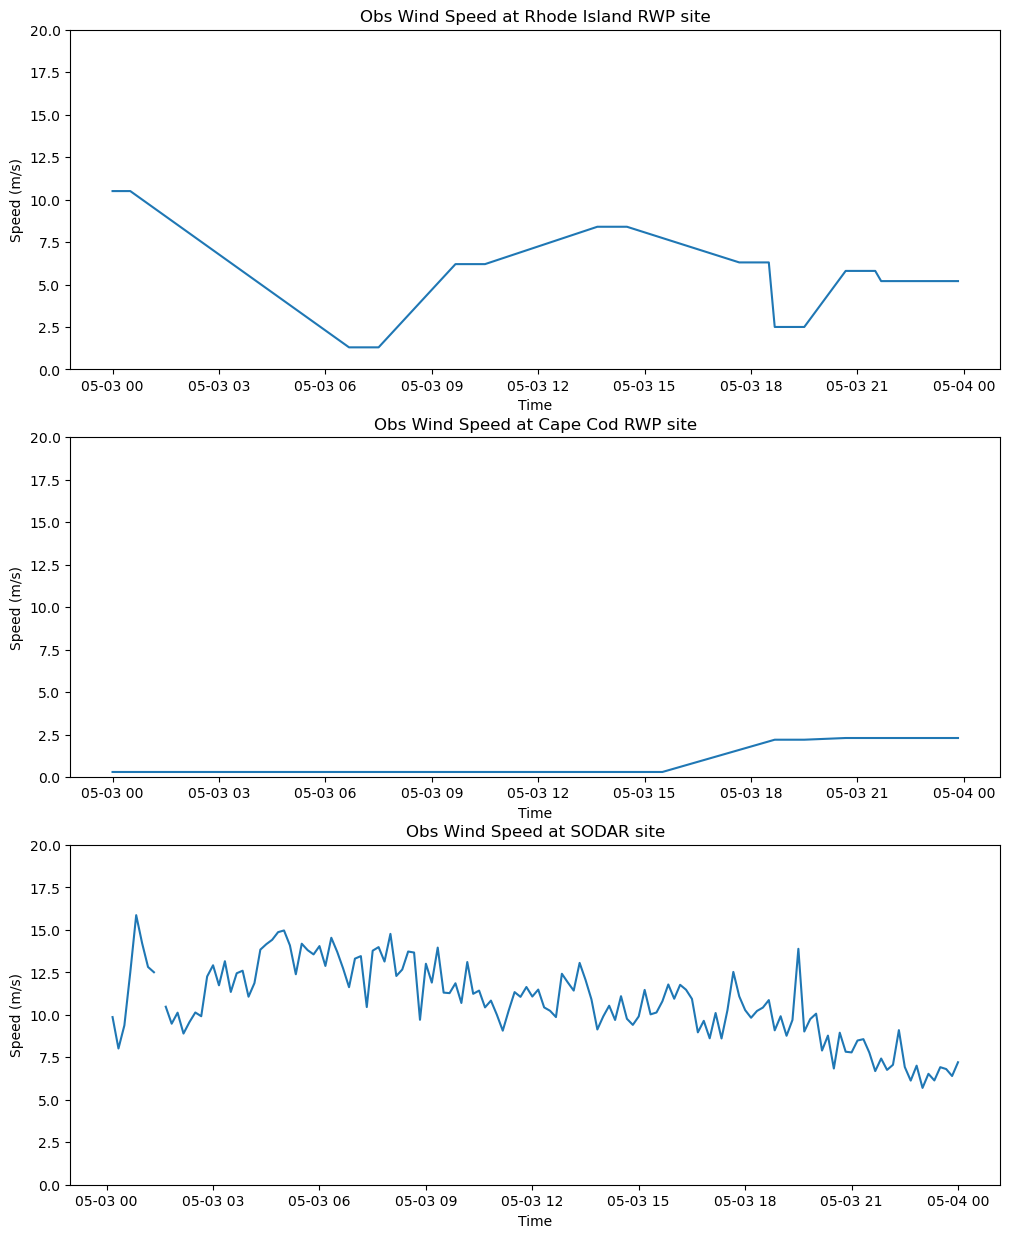

In [9]:
plt.figure(1, figsize=(12, 15))
ax=plt.subplot(311)
ax.plot(ds1_height.time, ds1_height.SPD)
ax.set_title(f'Obs Wind Speed at Rhode Island RWP site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax = plt.subplot(312)
ax.plot(ds3_height.time, ds3_height.SPD)
ax.set_title(f'Obs Wind Speed at Cape Cod RWP site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax = plt.subplot(313)
ax. plot(ds5_height.time, ds5_height.speed)
ax.set_title(f'Obs Wind Speed at SODAR site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_Obsspd.png', bbox_inches='tight', dpi=150)

And once again, wind direction:

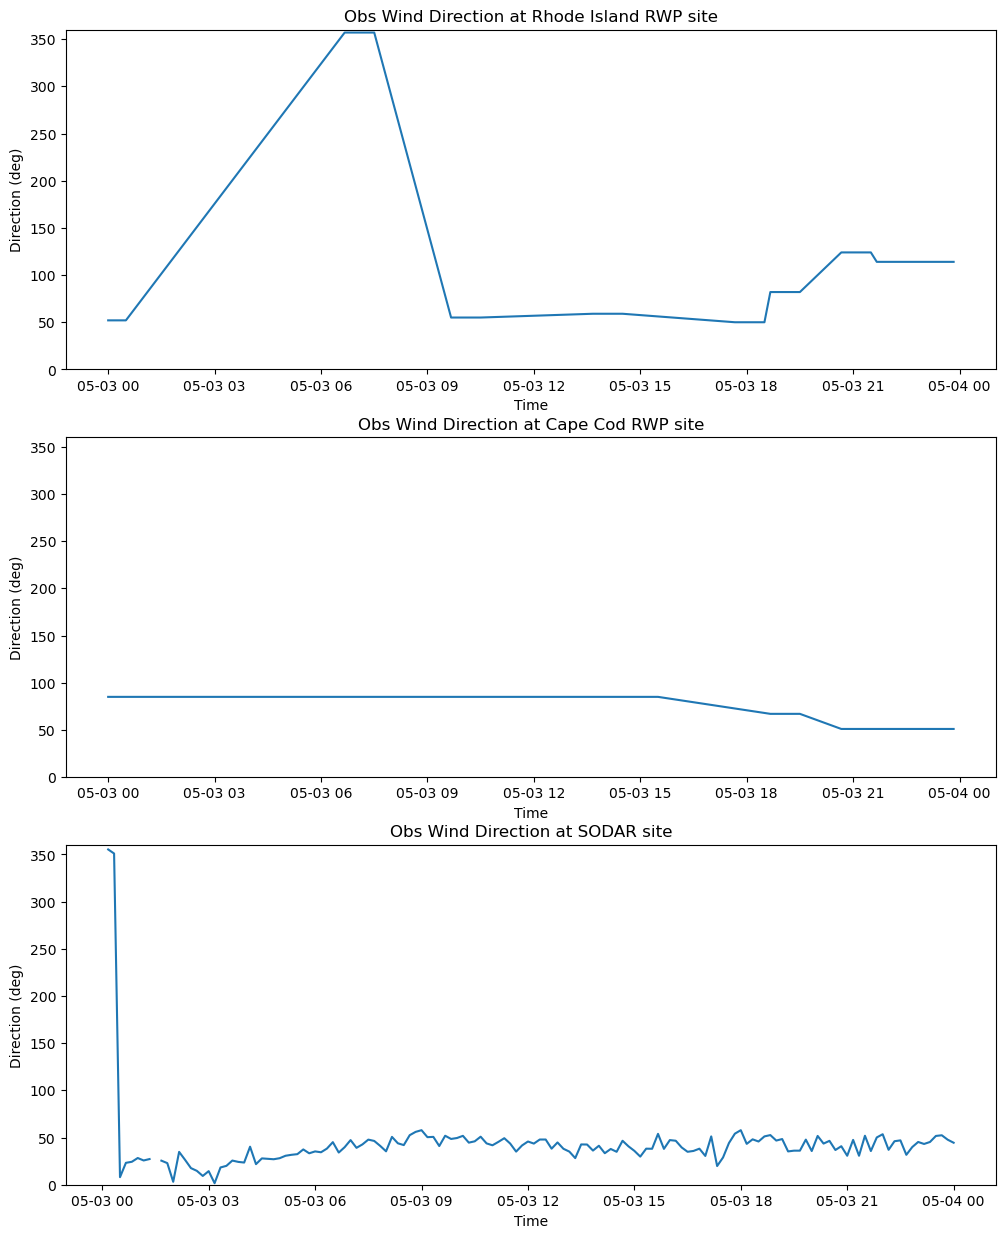

In [10]:
plt.figure(1, figsize=(12, 15))
ax=plt.subplot(311)
ax.plot(ds1_height.time, ds1_height.DIR)
ax.set_title(f'Obs Wind Direction at Rhode Island RWP site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax = plt.subplot(312)
ax.plot(ds3_height.time, ds3_height.DIR)
ax.set_title(f'Obs Wind Direction at Cape Cod RWP site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax = plt.subplot(313)
ax.plot(ds5_height.time, ds5_height.dir)
ax.set_title(f'Obs Wind Direction at SODAR site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_Obsdir.png', bbox_inches='tight', dpi=150)

## Comparing Model and Observed Data

Here is the good stuff.  This is where we put everything together, looking at both the model and observed wind data on the same graph.  First we will compare the wind speed data:

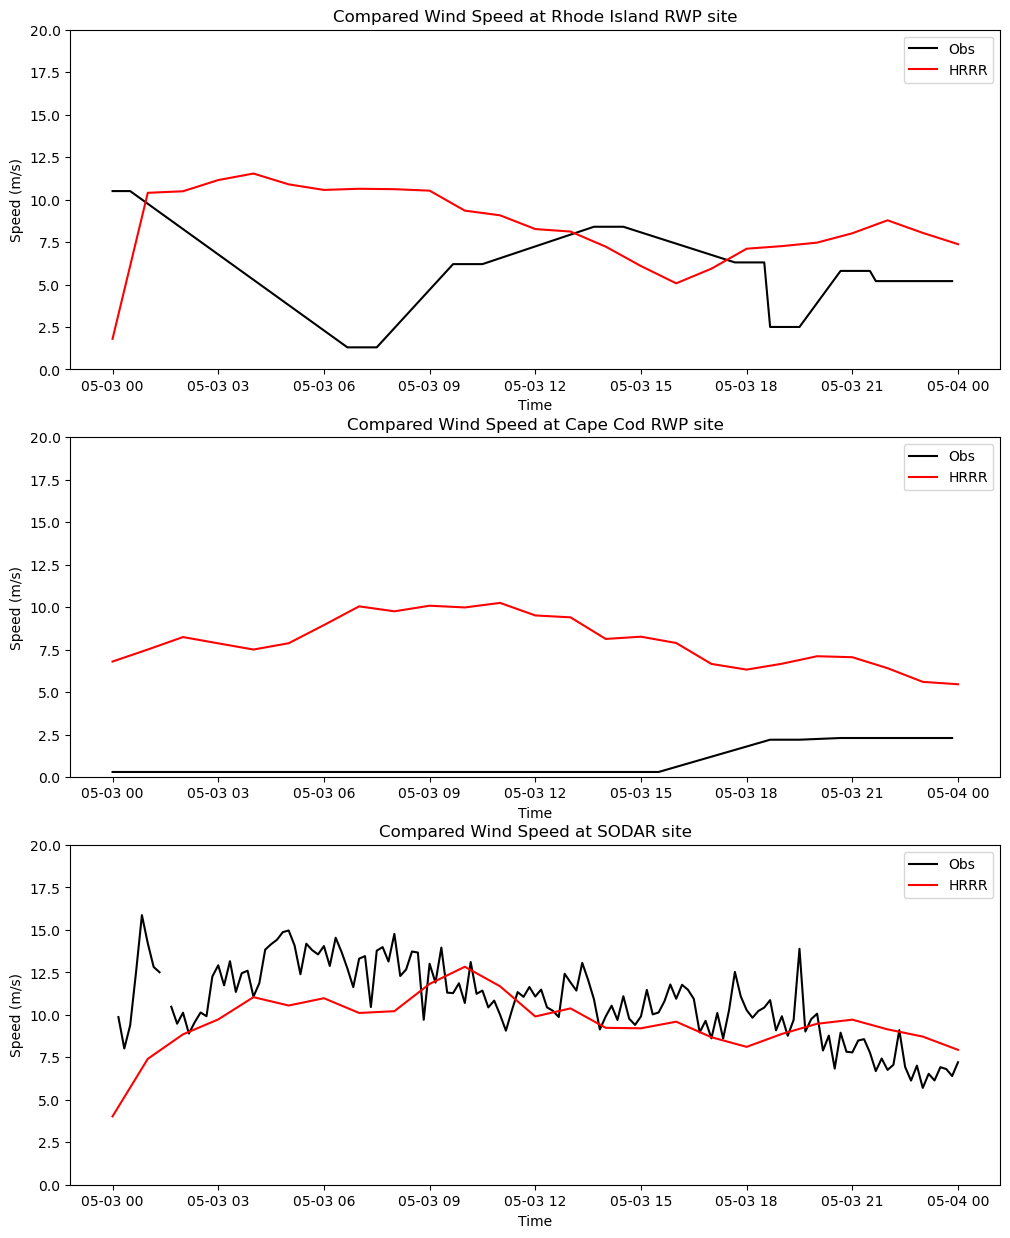

In [11]:
plt.figure(1, figsize=(12,15))
ax=plt.subplot(311)
ax.plot(ds1_height.time, ds1_height.SPD, color='black', label = 'Obs')
ax.plot(times, rhod_spd, color='red', label = 'HRRR')
ax.set_title(f'Compared Wind Speed at Rhode Island RWP site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax.legend()
ax=plt.subplot(312)
ax.plot(ds3_height.time, ds3_height.SPD, color='black', label = 'Obs')
ax.plot(times, caco_spd, color='red', label = 'HRRR')
ax.set_title(f'Compared Wind Speed at Cape Cod RWP site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax.legend()
ax=plt.subplot(313)
ax.plot(ds5_height.time, ds5_height.speed, color='black', label = 'Obs')
ax.plot(times, sodar_spd, color='red', label = 'HRRR')
ax.set_title(f'Compared Wind Speed at SODAR site')
ax.set_ylabel('Speed (m/s)')
ax.set_ylim(0, 20)
ax.set_xlabel('Time')
ax.legend()
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_Comparisonspd.png', bbox_inches='tight', dpi=150)

Finally, we will compare the wind direction data:

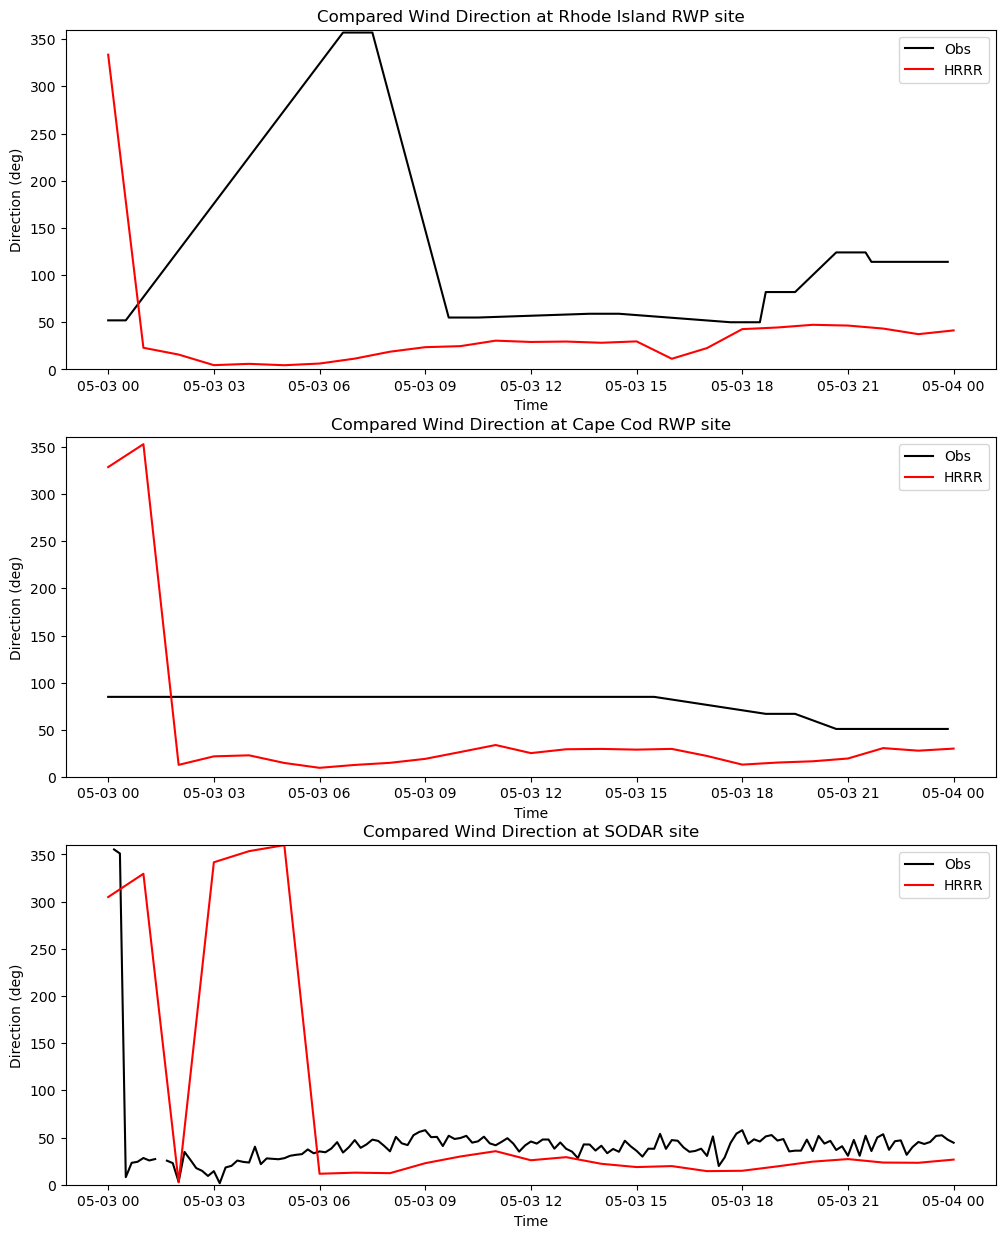

In [12]:
plt.figure(1, figsize=(12,15))
ax=plt.subplot(311)
ax.plot(ds1_height.time, ds1_height.DIR, color='black', label='Obs')
ax.plot(times, rhod_dir, color='red', label='HRRR')
ax.set_title(f'Compared Wind Direction at Rhode Island RWP site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax.legend()
ax=plt.subplot(312)
ax.plot(ds3_height.time, ds3_height.DIR, color='black', label = 'Obs')
ax.plot(times, caco_dir, color='red', label = 'HRRR')
ax.set_title(f'Compared Wind Direction at Cape Cod RWP site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax.legend()
ax=plt.subplot(313)
ax.plot(ds5_height.time, ds5_height.dir, color='black', label = 'Obs')
ax.plot(times, sodar_dir, color='red', label = 'HRRR')
ax.set_title(f'Compared Wind Direction at SODAR site')
ax.set_ylabel('Direction (deg)')
ax.set_ylim(0, 360)
ax.set_xlabel('Time')
ax.legend()
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_Comparisondir.png', bbox_inches='tight', dpi=150)

### Plotting Model Error

In [13]:
#Model data and observed data have different temporal resolution, 
#so we will once again have to do a time interpolation 
rhod_spd2=[]
rhod_dir2=[]
caco_spd2=[]
caco_dir2=[]
sodar_spd2=[]
sodar_dir2=[]
for g in range(0, 24):
    for h in range(0,6):
        rhod_spd2.append(rhod_spd[g])
        rhod_dir2.append(rhod_dir[g])
        caco_spd2.append(caco_spd[g])
        caco_dir2.append(caco_dir[g])
        sodar_spd2.append(sodar_spd[g])
        sodar_dir2.append(sodar_dir[g])

#Create a "zero line" to allow us to have a better visual of model error
zero_line=[]
for i in range(0, 144):
    zero_line.append(0)

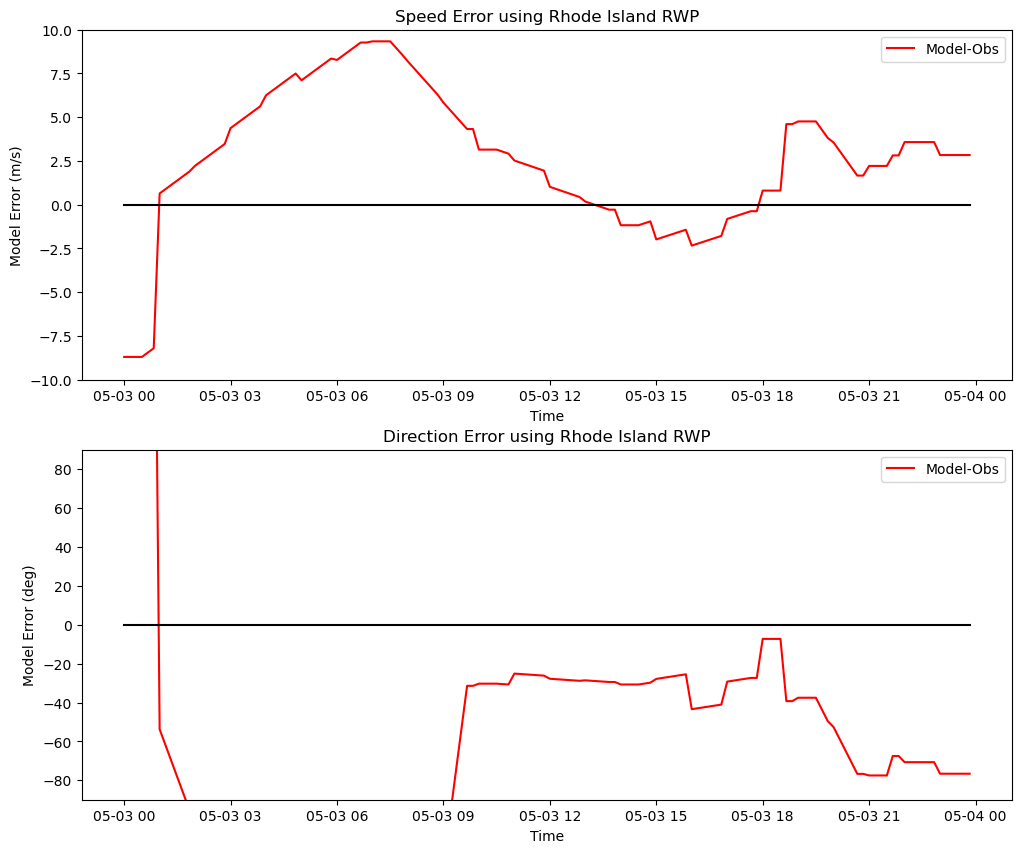

In [14]:
#And now we plot
#Rhode Island
plt.figure(1, figsize = (12, 10))
ax = plt.subplot(211)
ax.plot(ds1_height.time, rhod_spd2-ds1_height.SPD, color='red', label='Model-Obs')
ax.plot(ds1_height.time, zero_line, color='black')
ax.set_title('Speed Error using Rhode Island RWP')
ax.set_ylabel('Model Error (m/s)')
ax.set_ylim(-10, 10)
ax.set_xlabel('Time')
ax.legend()
ax = plt.subplot(212)
ax.plot(ds1_height.time, rhod_dir2-ds1_height.DIR, color='red', label='Model-Obs')
ax.plot(ds1_height.time, zero_line, color='black')
ax.set_title('Direction Error using Rhode Island RWP')
ax.set_ylabel('Model Error (deg)')
ax.set_ylim(-90, 90)
ax.set_xlabel('Time')
ax.legend()
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_MErhodrwp.png', bbox_inches='tight', dpi=150)

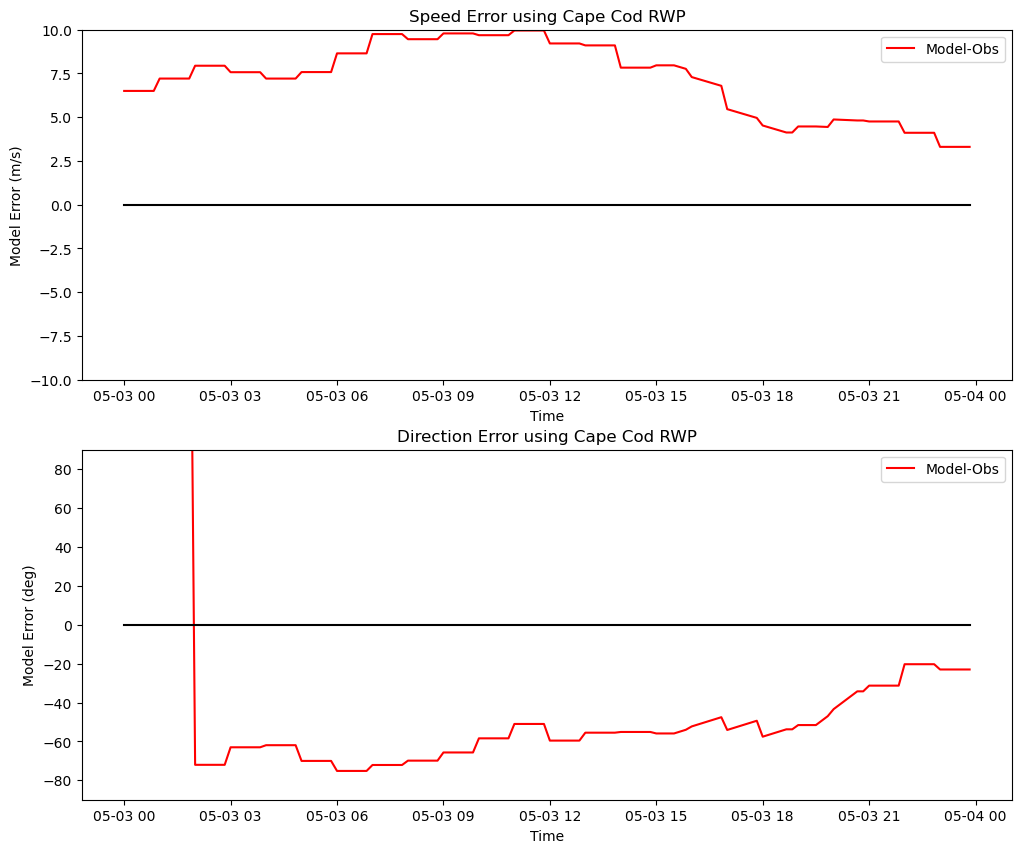

In [15]:
#Cape Cod
plt.figure(1, figsize = (12, 10))
ax = plt.subplot(211)
ax.plot(ds3_height.time, caco_spd2-ds3_height.SPD, color='red', label='Model-Obs')
ax.plot(ds3_height.time, zero_line, color='black')
ax.set_title('Speed Error using Cape Cod RWP')
ax.set_ylabel('Model Error (m/s)')
ax.set_ylim(-10, 10)
ax.set_xlabel('Time')
ax.legend()
ax = plt.subplot(212)
ax.plot(ds3_height.time, caco_dir2-ds3_height.DIR, color='red', label='Model-Obs')
ax.plot(ds3_height.time, zero_line, color='black')
ax.set_title('Direction Error using Cape Cod RWP')
ax.set_ylabel('Model Error (deg)')
ax.set_ylim(-90, 90)
ax.set_xlabel('Time')
ax.legend()
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_MEcacorwp.png', bbox_inches='tight', dpi=150)

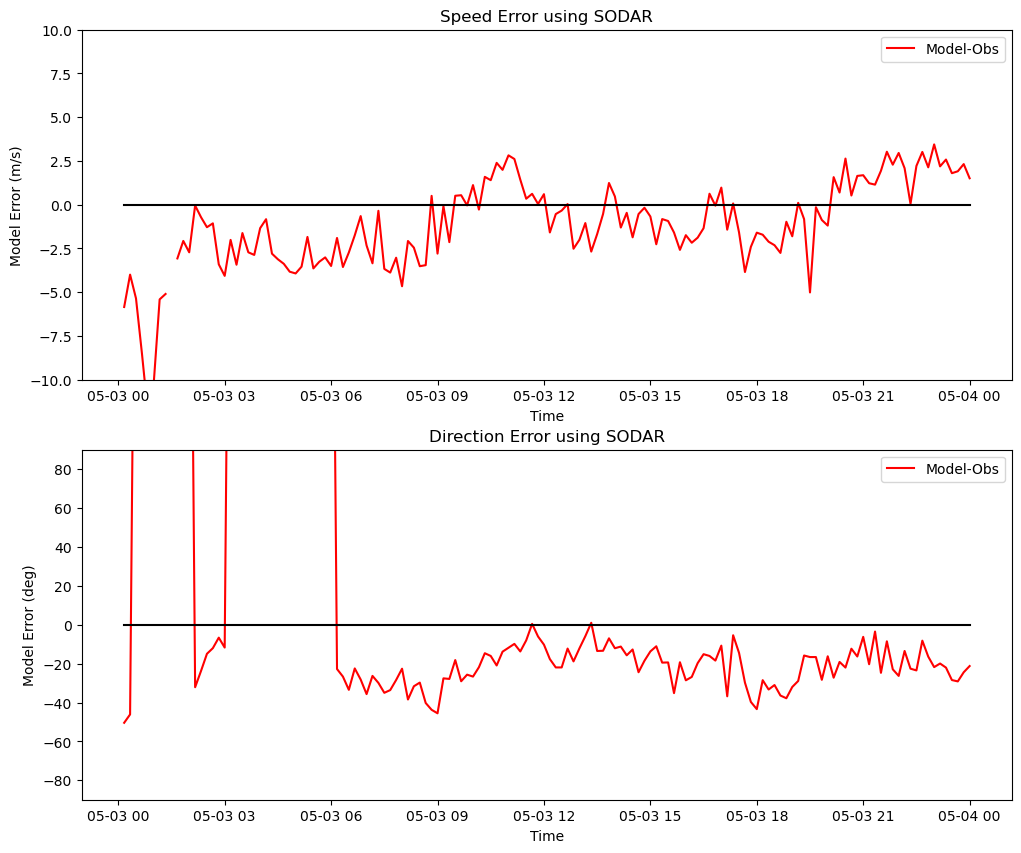

In [16]:
#Sodar
plt.figure(1, figsize = (12, 10))
ax = plt.subplot(211)
ax.plot(ds5_height.time, sodar_spd2-ds5_height.speed, color='red', label='Model-Obs')
ax.plot(ds5_height.time, zero_line, color='black')
ax.set_title('Speed Error using SODAR')
ax.set_ylabel('Model Error (m/s)')
ax.set_ylim(-10, 10)
ax.set_xlabel('Time')
ax.legend()
ax = plt.subplot(212)
ax.plot(ds5_height.time, sodar_dir2-ds5_height.dir, color='red', label='Model-Obs')
ax.plot(ds5_height.time, zero_line, color='black')
ax.set_title('Direction Error using SODAR')
ax.set_ylabel('Model Error (deg)')
ax.set_ylim(-90, 90)
ax.set_xlabel('Time')
ax.legend()
plt.savefig(f'../../../Downloads/{yr}{m}{dd}_MEsodar.png', bbox_inches='tight', dpi=150)

---

## Summary
*This section is currently being worked on.  Information will be added here in a future update.*

### What's next?
*This section is currently being worked on.  Information will be added here in a future update.*

#### Resources and references
*This section is currently being worked on.  Information will be added here in a future update.*